In [1]:
IRT_DIMS = 1
DATASET = 'test_matrix'    

In [2]:
import sys, os, shutil
import pickle
import time
import numpy as np
from utils import (mymode, load_data_heterogeneous, create_data_object_heterogeneous)
import seaborn as sns

from IRT import MIRT_2PL
from Heterogeneous_embedder import EmbedderHeterogeneous, train_embedder_heterogeneous, test_embedder_heterogeneous
from manage_experiments import perform_cross_validation

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [3]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# Initialise
parameters = {
    'df_name': None,
    'epochs': 10000,
    'learning_rate': 0.005,
    'weight_decay': 0,
    'early_stopping': 200,
    'n_splits': 10,
    'device': 'cuda:0',
    'batch_size': 1024
    }

if IRT_DIMS > 0:
    parameters['model_type'] = 'IRT'
    parameters['hidden_dims'] = IRT_DIMS
    parameters['lambda1'] = 0
    parameters['lambda2'] = 0
    OUTNAME = 'IRT'
else:
    parameters['model_type'] = 'GNN'
    parameters['hidden_dims'] = [16,8]
    OUTNAME = 'SAGE' 
    
print(parameters)
print(DATASET)

{'df_name': None, 'epochs': 10000, 'learning_rate': 0.005, 'weight_decay': 0, 'early_stopping': 200, 'n_splits': 10, 'device': 'cuda:0', 'batch_size': 1024, 'model_type': 'IRT', 'hidden_dims': 1, 'lambda1': 0, 'lambda2': 0}
test_matrix


In [5]:
DATA_FILE = 'data/mindsteps_set_' + DATASET
df = load_data_heterogeneous(DATA_FILE)
data, df_student, df_item, df_edge = create_data_object_heterogeneous(df, return_aux_data=True)

(327841, 24)


In [6]:
df.columns

Index(['studentId', 'code', 'motherTongue', 'Gender', 'scale', 'matrix',
       'IRT_difficulty', 'topic', 'responseformat', 'textlength', 'score',
       'age', 'grade', 'viewingTime', 'timestamp', 'useCase', 'assessmentId',
       'ability', 'frequency', 'previous_sessions', 'years_from_start',
       'matdiff', 'matcode', 'domain'],
      dtype='object')

In [7]:
df.head()

,studentId,code,motherTongue,Gender,scale,matrix,IRT_difficulty,topic,responseformat,textlength,...,timestamp,useCase,assessmentId,ability,frequency,previous_sessions,years_from_start,matdiff,matcode,domain
0,0,0,0.0,0.0,dles,D.2.B.1.f,0.268748,Zeitungsartikel,NaN,NaN,...,7.643058e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d
1,0,1,0.0,0.0,dles,D.2.B.1.h,1.217388,Textsorten erkennen,single choice,NaN,...,7.643061e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d
2,0,2,0.0,0.0,dles,D.2.B.1.h,1.584145,Wissenstexte: Mix,single choice,NaN,...,7.845624e-312,ms-kber,E109B3CDD31EDCFE7F48665587372C60A3FAEBB8571544...,2.421279,4.137915,6,1.45,,,d
3,0,3,0.0,0.0,dles,D.2.B.1.h,1.584145,Wissenstexte: Mix,single choice,NaN,...,7.851631e-312,ms-kber,319A0FE3AFDC0A30C4C1B26577B5B19FE66E918A181354...,2.174872,7.432378,11,1.48,,,d
4,0,4,0.0,0.0,dles,D.2.C.1.h,1.172410,Geschichten lang,single choice,NaN,...,7.643059e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d


edge_dim = data['student', 'responds', 'item'].edge_attr.shape[1]
if IRT_DIMS > 0:
    model = MIRT_2PL(IRT_DIMS, edge_dim, data)
else:
    model = EmbedderHeterogeneous( 
        n_students =  data['student'].x.size(0),
        n_items = data['item'].x.size(0),
        student_inchannel = data['student'].x.size(1),
        item_inchannel = data['item'].x.size(1),
        hidden_channels=parameters['hidden_dims'],
        edge_channel=edge_dim,
        metadata=data.metadata()
        ).to(device)
    
model = model.to(device)

In [8]:
output_dict, model = perform_cross_validation(data, parameters, save_embeddings=True, save_subgraph=True, final_fit=True)

0it [00:00, ?it/s]
  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.50it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.31it/s]

100%|██████████| 4/4 [00:00<00:00,  6.43it/s]

  0%|          | 1/10000 [00:00<2:00:49,  1.38it/s]


Epoch: 001, Loss: 0.7311, Val: 0.5018, Test: 0.5013




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.30it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.76it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.63it/s]

100%|██████████| 4/4 [00:00<00:00,  5.78it/s]

  0%|          | 2/10000 [00:01<2:14:55,  1.24it/s]


Epoch: 002, Loss: 0.7044, Val: 0.5054, Test: 0.5026




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.70it/s]

100%|██████████| 4/4 [00:00<00:00,  8.49it/s]



Epoch: 003, Loss: 0.6933, Val: 0.5090, Test: 0.5047



  0%|          | 3/10000 [00:02<2:12:02,  1.26it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.28it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.55it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.23it/s]

100%|██████████| 4/4 [00:00<00:00,  5.58it/s]

  0%|          | 4/10000 [00:03<2:15:07,  1.23it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.12it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.50it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.53it/s]

100%|██████████| 4/4 [00:00<00:00,  5.84it/s]

  0%|          | 5/10000 [00:04<2:18:09,  1.21it/s]


Epoch: 005, Loss: 0.6620, Val: 0.5118, Test: 0.5081




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.35it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.03it/s]

100%|██████████| 4/4 [00:00<00:00,  6.91it/s]

  0%|          | 6/10000 [00:04<2:13:29,  1.25it/s]


Epoch: 006, Loss: 0.6538, Val: 0.5125, Test: 0.5092




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.58it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.99it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.13it/s]

100%|██████████| 4/4 [00:00<00:00,  7.29it/s]

  0%|          | 7/10000 [00:05<2:09:58,  1.28it/s]


Epoch: 007, Loss: 0.6566, Val: 0.5132, Test: 0.5116




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.92it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.23it/s]

100%|██████████| 4/4 [00:00<00:00,  6.35it/s]

  0%|          | 8/10000 [00:06<2:08:58,  1.29it/s]


Epoch: 008, Loss: 0.6420, Val: 0.5138, Test: 0.5133




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.41it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.09it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.47it/s]

100%|██████████| 4/4 [00:00<00:00,  6.15it/s]

  0%|          | 9/10000 [00:07<2:11:29,  1.27it/s]


Epoch: 009, Loss: 0.6406, Val: 0.5151, Test: 0.5146




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.91it/s]

100%|██████████| 4/4 [00:00<00:00,  7.69it/s]

  0%|          | 10/10000 [00:07<2:03:49,  1.34it/s]


Epoch: 010, Loss: 0.6293, Val: 0.5170, Test: 0.5172




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.66it/s]

100%|██████████| 4/4 [00:00<00:00,  9.39it/s]

  0%|          | 11/10000 [00:08<2:01:56,  1.37it/s]


Epoch: 011, Loss: 0.6307, Val: 0.5194, Test: 0.5185




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.94it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.87it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.33it/s]

100%|██████████| 4/4 [00:00<00:00,  5.77it/s]

  0%|          | 12/10000 [00:09<2:16:05,  1.22it/s]


Epoch: 012, Loss: 0.6195, Val: 0.5222, Test: 0.5200




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.46it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.69it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.70it/s]

100%|██████████| 4/4 [00:00<00:00,  6.74it/s]

  0%|          | 13/10000 [00:10<2:13:16,  1.25it/s]


Epoch: 013, Loss: 0.6189, Val: 0.5252, Test: 0.5221




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.95it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.35it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.22it/s]

100%|██████████| 4/4 [00:00<00:00,  4.67it/s]

  0%|          | 14/10000 [00:11<2:27:37,  1.13it/s]


Epoch: 014, Loss: 0.6080, Val: 0.5275, Test: 0.5248




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.48it/s]

100%|██████████| 4/4 [00:00<00:00,  6.29it/s]

  0%|          | 15/10000 [00:12<2:29:39,  1.11it/s]


Epoch: 015, Loss: 0.6123, Val: 0.5285, Test: 0.5267




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.36it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.09it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.88it/s]

100%|██████████| 4/4 [00:00<00:00,  5.99it/s]

  0%|          | 16/10000 [00:13<2:27:26,  1.13it/s]


Epoch: 016, Loss: 0.6054, Val: 0.5311, Test: 0.5293




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.60it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.82it/s]

100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

  0%|          | 17/10000 [00:13<2:20:25,  1.18it/s]


Epoch: 017, Loss: 0.5967, Val: 0.5324, Test: 0.5320




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.87it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.05it/s]

100%|██████████| 4/4 [00:00<00:00,  6.52it/s]

  0%|          | 18/10000 [00:14<2:25:10,  1.15it/s]


Epoch: 018, Loss: 0.5934, Val: 0.5338, Test: 0.5338




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.58it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.48it/s]

100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

  0%|          | 19/10000 [00:15<2:14:30,  1.24it/s]


Epoch: 019, Loss: 0.5892, Val: 0.5357, Test: 0.5356




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.64it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.18it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.85it/s]

100%|██████████| 4/4 [00:00<00:00,  4.42it/s]

  0%|          | 20/10000 [00:16<2:25:43,  1.14it/s]


Epoch: 020, Loss: 0.5864, Val: 0.5382, Test: 0.5361




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.94it/s]

100%|██████████| 4/4 [00:00<00:00,  7.51it/s]

  0%|          | 21/10000 [00:17<2:15:40,  1.23it/s]


Epoch: 021, Loss: 0.5850, Val: 0.5408, Test: 0.5379




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.46it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.01it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.77it/s]

100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

  0%|          | 22/10000 [00:18<2:17:48,  1.21it/s]


Epoch: 022, Loss: 0.5759, Val: 0.5422, Test: 0.5406




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.09it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.22it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.52it/s]

100%|██████████| 4/4 [00:00<00:00,  5.80it/s]

  0%|          | 23/10000 [00:18<2:20:33,  1.18it/s]


Epoch: 023, Loss: 0.5738, Val: 0.5432, Test: 0.5434




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.34it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.05it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.65it/s]

100%|██████████| 4/4 [00:00<00:00,  6.67it/s]

  0%|          | 24/10000 [00:19<2:18:51,  1.20it/s]


Epoch: 024, Loss: 0.5714, Val: 0.5449, Test: 0.5452




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.71it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.04it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.29it/s]

100%|██████████| 4/4 [00:00<00:00,  6.06it/s]

  0%|          | 25/10000 [00:20<2:27:52,  1.12it/s]


Epoch: 025, Loss: 0.5637, Val: 0.5479, Test: 0.5474




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.04it/s]

100%|██████████| 4/4 [00:00<00:00, 10.09it/s]

  0%|          | 26/10000 [00:21<2:10:45,  1.27it/s]


Epoch: 026, Loss: 0.5642, Val: 0.5492, Test: 0.5490




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.86it/s]

100%|██████████| 4/4 [00:00<00:00, 10.43it/s]

  0%|          | 27/10000 [00:21<1:56:21,  1.43it/s]


Epoch: 027, Loss: 0.5561, Val: 0.5515, Test: 0.5501




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.82it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.34it/s]

100%|██████████| 4/4 [00:00<00:00,  8.18it/s]

  0%|          | 28/10000 [00:22<1:53:10,  1.47it/s]


Epoch: 028, Loss: 0.5575, Val: 0.5535, Test: 0.5518




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.78it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.14it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.80it/s]

100%|██████████| 4/4 [00:00<00:00,  6.14it/s]

  0%|          | 29/10000 [00:23<2:02:45,  1.35it/s]


Epoch: 029, Loss: 0.5510, Val: 0.5553, Test: 0.5540




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

100%|██████████| 4/4 [00:00<00:00,  5.51it/s]

  0%|          | 30/10000 [00:24<2:10:59,  1.27it/s]


Epoch: 030, Loss: 0.5485, Val: 0.5573, Test: 0.5558




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.81it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.14it/s]

100%|██████████| 4/4 [00:00<00:00,  5.79it/s]

  0%|          | 31/10000 [00:25<2:15:03,  1.23it/s]


Epoch: 031, Loss: 0.5427, Val: 0.5596, Test: 0.5581




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.36it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.83it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.25it/s]

100%|██████████| 4/4 [00:00<00:00,  6.97it/s]

  0%|          | 32/10000 [00:25<2:11:14,  1.27it/s]


Epoch: 032, Loss: 0.5444, Val: 0.5617, Test: 0.5598




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.80it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.29it/s]

100%|██████████| 4/4 [00:00<00:00, 10.73it/s]

  0%|          | 33/10000 [00:26<1:56:39,  1.42it/s]


Epoch: 033, Loss: 0.5412, Val: 0.5631, Test: 0.5622




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.35it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.14it/s]

100%|██████████| 4/4 [00:00<00:00,  8.13it/s]

  0%|          | 34/10000 [00:27<1:56:09,  1.43it/s]


Epoch: 034, Loss: 0.5369, Val: 0.5660, Test: 0.5633




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.23it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.66it/s]

100%|██████████| 4/4 [00:00<00:00, 10.20it/s]

  0%|          | 35/10000 [00:27<1:47:29,  1.55it/s]


Epoch: 035, Loss: 0.5361, Val: 0.5685, Test: 0.5647




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.46it/s]

100%|██████████| 4/4 [00:00<00:00,  9.47it/s]

  0%|          | 36/10000 [00:28<1:43:45,  1.60it/s]


Epoch: 036, Loss: 0.5327, Val: 0.5699, Test: 0.5669




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.02it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.71it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.61it/s]

100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

  0%|          | 37/10000 [00:28<1:55:01,  1.44it/s]


Epoch: 037, Loss: 0.5286, Val: 0.5718, Test: 0.5694




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.98it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.94it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.91it/s]

100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

  0%|          | 38/10000 [00:29<2:07:35,  1.30it/s]


Epoch: 038, Loss: 0.5233, Val: 0.5734, Test: 0.5712




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.56it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.44it/s]

100%|██████████| 4/4 [00:00<00:00,  5.90it/s]

  0%|          | 39/10000 [00:30<2:13:36,  1.24it/s]


Epoch: 039, Loss: 0.5236, Val: 0.5742, Test: 0.5732




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.89it/s]

100%|██████████| 4/4 [00:00<00:00,  5.91it/s]

  0%|          | 40/10000 [00:31<2:15:19,  1.23it/s]


Epoch: 040, Loss: 0.5183, Val: 0.5758, Test: 0.5757




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.65it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

100%|██████████| 4/4 [00:00<00:00,  4.80it/s]

  0%|          | 41/10000 [00:32<2:28:54,  1.11it/s]


Epoch: 041, Loss: 0.5210, Val: 0.5767, Test: 0.5777




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.40it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.34it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.28it/s]

100%|██████████| 4/4 [00:00<00:00,  6.32it/s]

  0%|          | 42/10000 [00:33<2:40:46,  1.03it/s]


Epoch: 042, Loss: 0.5208, Val: 0.5786, Test: 0.5803




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.72it/s]

100%|██████████| 4/4 [00:00<00:00, 14.33it/s]

  0%|          | 43/10000 [00:34<2:14:57,  1.23it/s]


Epoch: 043, Loss: 0.5122, Val: 0.5798, Test: 0.5821




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.73it/s]

100%|██████████| 4/4 [00:00<00:00, 12.72it/s]

  0%|          | 44/10000 [00:34<1:56:08,  1.43it/s]


Epoch: 044, Loss: 0.5118, Val: 0.5816, Test: 0.5841




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.57it/s]

100%|██████████| 4/4 [00:00<00:00, 14.38it/s]

  0%|          | 45/10000 [00:35<1:41:42,  1.63it/s]


Epoch: 045, Loss: 0.5067, Val: 0.5833, Test: 0.5855




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.10it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.08it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.09it/s]

100%|██████████| 4/4 [00:00<00:00,  7.51it/s]

  0%|          | 46/10000 [00:35<1:46:05,  1.56it/s]


Epoch: 046, Loss: 0.5091, Val: 0.5858, Test: 0.5874




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.20it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.05it/s]

100%|██████████| 4/4 [00:00<00:00,  9.73it/s]

  0%|          | 47/10000 [00:36<1:43:00,  1.61it/s]


Epoch: 047, Loss: 0.5004, Val: 0.5871, Test: 0.5887




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.32it/s]

100%|██████████| 4/4 [00:00<00:00, 12.17it/s]

  0%|          | 48/10000 [00:36<1:35:12,  1.74it/s]


Epoch: 048, Loss: 0.5035, Val: 0.5888, Test: 0.5901




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.44it/s]

100%|██████████| 4/4 [00:00<00:00, 13.08it/s]

  0%|          | 49/10000 [00:37<1:27:56,  1.89it/s]


Epoch: 049, Loss: 0.5020, Val: 0.5901, Test: 0.5917




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.94it/s]

100%|██████████| 4/4 [00:00<00:00,  9.53it/s]

  0%|          | 50/10000 [00:37<1:28:33,  1.87it/s]


Epoch: 050, Loss: 0.5000, Val: 0.5918, Test: 0.5938




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.31it/s]

100%|██████████| 4/4 [00:00<00:00, 11.09it/s]

  1%|          | 51/10000 [00:38<1:26:42,  1.91it/s]


Epoch: 051, Loss: 0.5020, Val: 0.5938, Test: 0.5958




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.39it/s]

100%|██████████| 4/4 [00:00<00:00, 10.69it/s]

  1%|          | 52/10000 [00:38<1:25:35,  1.94it/s]


Epoch: 052, Loss: 0.4936, Val: 0.5954, Test: 0.5962




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.72it/s]

100%|██████████| 4/4 [00:00<00:00, 10.88it/s]

  1%|          | 53/10000 [00:39<1:24:09,  1.97it/s]


Epoch: 053, Loss: 0.4909, Val: 0.5962, Test: 0.5984




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.38it/s]

100%|██████████| 4/4 [00:00<00:00, 12.41it/s]

  1%|          | 54/10000 [00:39<1:20:44,  2.05it/s]


Epoch: 054, Loss: 0.4909, Val: 0.5972, Test: 0.5998




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.03it/s]

100%|██████████| 4/4 [00:00<00:00, 10.05it/s]

  1%|          | 55/10000 [00:40<1:23:02,  2.00it/s]


Epoch: 055, Loss: 0.4890, Val: 0.5993, Test: 0.6025




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.84it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.51it/s]

100%|██████████| 4/4 [00:00<00:00,  9.69it/s]

  1%|          | 56/10000 [00:40<1:24:57,  1.95it/s]


Epoch: 056, Loss: 0.4886, Val: 0.6002, Test: 0.6041




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.41it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.48it/s]

100%|██████████| 4/4 [00:00<00:00,  9.44it/s]

  1%|          | 57/10000 [00:41<1:26:54,  1.91it/s]


Epoch: 057, Loss: 0.4866, Val: 0.6016, Test: 0.6063




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.32it/s]

100%|██████████| 4/4 [00:00<00:00, 10.12it/s]

  1%|          | 58/10000 [00:41<1:26:59,  1.90it/s]


Epoch: 058, Loss: 0.4837, Val: 0.6023, Test: 0.6079




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.04it/s]

100%|██████████| 4/4 [00:00<00:00, 10.69it/s]

  1%|          | 59/10000 [00:42<1:26:12,  1.92it/s]


Epoch: 059, Loss: 0.4832, Val: 0.6033, Test: 0.6094




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.29it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.18it/s]

100%|██████████| 4/4 [00:00<00:00, 10.19it/s]

  1%|          | 60/10000 [00:42<1:26:26,  1.92it/s]


Epoch: 060, Loss: 0.4817, Val: 0.6049, Test: 0.6111




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.81it/s]

100%|██████████| 4/4 [00:00<00:00, 12.16it/s]

  1%|          | 61/10000 [00:43<1:23:49,  1.98it/s]


Epoch: 061, Loss: 0.4769, Val: 0.6063, Test: 0.6120




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.75it/s]

100%|██████████| 4/4 [00:00<00:00, 12.01it/s]

  1%|          | 62/10000 [00:43<1:22:18,  2.01it/s]


Epoch: 062, Loss: 0.4802, Val: 0.6078, Test: 0.6137




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.77it/s]

100%|██████████| 4/4 [00:00<00:00, 11.59it/s]

  1%|          | 63/10000 [00:44<1:20:51,  2.05it/s]


Epoch: 063, Loss: 0.4758, Val: 0.6079, Test: 0.6150




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.96it/s]

100%|██████████| 4/4 [00:00<00:00, 11.89it/s]

  1%|          | 64/10000 [00:44<1:20:24,  2.06it/s]


Epoch: 064, Loss: 0.4750, Val: 0.6104, Test: 0.6153




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.94it/s]

100%|██████████| 4/4 [00:00<00:00,  6.81it/s]

  1%|          | 65/10000 [00:45<1:37:06,  1.71it/s]


Epoch: 065, Loss: 0.4741, Val: 0.6120, Test: 0.6167




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.12it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.11it/s]

100%|██████████| 4/4 [00:00<00:00,  7.73it/s]

  1%|          | 66/10000 [00:46<1:41:02,  1.64it/s]


Epoch: 066, Loss: 0.4720, Val: 0.6121, Test: 0.6183




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.34it/s]

100%|██████████| 4/4 [00:00<00:00,  8.95it/s]

  1%|          | 67/10000 [00:46<1:40:08,  1.65it/s]


Epoch: 067, Loss: 0.4708, Val: 0.6137, Test: 0.6198




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.20it/s]

100%|██████████| 4/4 [00:00<00:00, 10.58it/s]

  1%|          | 68/10000 [00:47<1:35:42,  1.73it/s]


Epoch: 068, Loss: 0.4683, Val: 0.6155, Test: 0.6208




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.86it/s]

100%|██████████| 4/4 [00:00<00:00, 10.76it/s]

  1%|          | 69/10000 [00:47<1:33:23,  1.77it/s]


Epoch: 069, Loss: 0.4696, Val: 0.6167, Test: 0.6223




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.76it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.14it/s]

100%|██████████| 4/4 [00:00<00:00,  7.66it/s]

  1%|          | 70/10000 [00:48<1:36:52,  1.71it/s]


Epoch: 070, Loss: 0.4702, Val: 0.6178, Test: 0.6245




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.98it/s]

100%|██████████| 4/4 [00:00<00:00, 14.54it/s]

  1%|          | 71/10000 [00:49<1:27:09,  1.90it/s]


Epoch: 071, Loss: 0.4669, Val: 0.6190, Test: 0.6263




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.58it/s]

100%|██████████| 4/4 [00:00<00:00, 13.89it/s]

  1%|          | 72/10000 [00:49<1:21:08,  2.04it/s]


Epoch: 072, Loss: 0.4642, Val: 0.6203, Test: 0.6273




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.33it/s]

100%|██████████| 4/4 [00:00<00:00, 14.28it/s]

  1%|          | 73/10000 [00:49<1:16:21,  2.17it/s]


Epoch: 073, Loss: 0.4624, Val: 0.6212, Test: 0.6287




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.39it/s]

100%|██████████| 4/4 [00:00<00:00, 12.33it/s]

  1%|          | 74/10000 [00:50<1:15:15,  2.20it/s]


Epoch: 074, Loss: 0.4591, Val: 0.6229, Test: 0.6299




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.60it/s]

100%|██████████| 4/4 [00:00<00:00, 13.78it/s]

  1%|          | 75/10000 [00:50<1:12:29,  2.28it/s]


Epoch: 075, Loss: 0.4606, Val: 0.6242, Test: 0.6317




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.24it/s]

100%|██████████| 4/4 [00:00<00:00, 14.19it/s]

  1%|          | 76/10000 [00:51<1:10:15,  2.35it/s]


Epoch: 076, Loss: 0.4595, Val: 0.6251, Test: 0.6329




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.90it/s]

100%|██████████| 4/4 [00:00<00:00, 14.36it/s]

  1%|          | 77/10000 [00:51<1:08:23,  2.42it/s]


Epoch: 077, Loss: 0.4586, Val: 0.6271, Test: 0.6340




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.78it/s]

100%|██████████| 4/4 [00:00<00:00, 13.99it/s]

  1%|          | 78/10000 [00:51<1:07:40,  2.44it/s]


Epoch: 078, Loss: 0.4589, Val: 0.6283, Test: 0.6355




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.39it/s]

100%|██████████| 4/4 [00:00<00:00, 12.78it/s]

  1%|          | 79/10000 [00:52<1:08:45,  2.40it/s]


Epoch: 079, Loss: 0.4547, Val: 0.6306, Test: 0.6366




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.31it/s]

100%|██████████| 4/4 [00:00<00:00, 14.19it/s]

  1%|          | 80/10000 [00:52<1:07:24,  2.45it/s]


Epoch: 080, Loss: 0.4558, Val: 0.6321, Test: 0.6383




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.84it/s]

100%|██████████| 4/4 [00:00<00:00, 14.43it/s]

  1%|          | 81/10000 [00:53<1:06:23,  2.49it/s]


Epoch: 081, Loss: 0.4516, Val: 0.6332, Test: 0.6395




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.17it/s]

100%|██████████| 4/4 [00:00<00:00, 13.44it/s]

  1%|          | 82/10000 [00:53<1:07:04,  2.46it/s]


Epoch: 082, Loss: 0.4536, Val: 0.6350, Test: 0.6410




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.55it/s]

100%|██████████| 4/4 [00:00<00:00, 12.92it/s]

  1%|          | 83/10000 [00:53<1:08:04,  2.43it/s]


Epoch: 083, Loss: 0.4517, Val: 0.6359, Test: 0.6425




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.30it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.15it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.72it/s]

100%|██████████| 4/4 [00:00<00:00,  7.01it/s]

  1%|          | 84/10000 [00:54<1:24:15,  1.96it/s]


Epoch: 084, Loss: 0.4505, Val: 0.6372, Test: 0.6436




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.82it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.12it/s]

100%|██████████| 4/4 [00:00<00:00,  8.15it/s]

  1%|          | 85/10000 [00:55<1:31:07,  1.81it/s]


Epoch: 085, Loss: 0.4476, Val: 0.6381, Test: 0.6448




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.78it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.56it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.51it/s]

100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

  1%|          | 86/10000 [00:55<1:36:46,  1.71it/s]


Epoch: 086, Loss: 0.4440, Val: 0.6390, Test: 0.6458




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.65it/s]

100%|██████████| 4/4 [00:00<00:00, 14.38it/s]

  1%|          | 87/10000 [00:56<1:29:00,  1.86it/s]


Epoch: 087, Loss: 0.4522, Val: 0.6405, Test: 0.6469




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.20it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.86it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.83it/s]

100%|██████████| 4/4 [00:00<00:00,  8.12it/s]

  1%|          | 88/10000 [00:57<1:34:48,  1.74it/s]


Epoch: 088, Loss: 0.4453, Val: 0.6418, Test: 0.6477




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.64it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  8.80it/s]

100%|██████████| 4/4 [00:00<00:00,  8.46it/s]

  1%|          | 89/10000 [00:57<1:37:48,  1.69it/s]


Epoch: 089, Loss: 0.4490, Val: 0.6425, Test: 0.6488




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.29it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.96it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.32it/s]

100%|██████████| 4/4 [00:00<00:00,  6.53it/s]

  1%|          | 90/10000 [00:58<1:48:42,  1.52it/s]


Epoch: 090, Loss: 0.4447, Val: 0.6444, Test: 0.6496




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.38it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.36it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.04it/s]

100%|██████████| 4/4 [00:00<00:00,  7.18it/s]

  1%|          | 91/10000 [00:59<1:52:07,  1.47it/s]


Epoch: 091, Loss: 0.4429, Val: 0.6457, Test: 0.6507




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.33it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.17it/s]

100%|██████████| 4/4 [00:00<00:00,  6.63it/s]

  1%|          | 92/10000 [01:00<1:59:44,  1.38it/s]


Epoch: 092, Loss: 0.4417, Val: 0.6481, Test: 0.6512




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.07it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.31it/s]

100%|██████████| 4/4 [00:00<00:00,  7.67it/s]

  1%|          | 93/10000 [01:00<1:57:34,  1.40it/s]


Epoch: 093, Loss: 0.4448, Val: 0.6495, Test: 0.6521




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.18it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.08it/s]

100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

  1%|          | 94/10000 [01:01<1:59:14,  1.38it/s]


Epoch: 094, Loss: 0.4425, Val: 0.6504, Test: 0.6530




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.87it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.64it/s]

100%|██████████| 4/4 [00:00<00:00,  7.24it/s]

  1%|          | 95/10000 [01:02<1:56:55,  1.41it/s]


Epoch: 095, Loss: 0.4376, Val: 0.6508, Test: 0.6544




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.52it/s]

100%|██████████| 4/4 [00:00<00:00,  8.75it/s]

  1%|          | 96/10000 [01:02<1:55:54,  1.42it/s]


Epoch: 096, Loss: 0.4402, Val: 0.6513, Test: 0.6555




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.49it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.35it/s]

100%|██████████| 4/4 [00:00<00:00,  8.62it/s]

  1%|          | 97/10000 [01:03<1:51:51,  1.48it/s]


Epoch: 097, Loss: 0.4375, Val: 0.6529, Test: 0.6565




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.65it/s]

100%|██████████| 4/4 [00:00<00:00, 12.15it/s]

  1%|          | 98/10000 [01:03<1:45:06,  1.57it/s]


Epoch: 098, Loss: 0.4369, Val: 0.6537, Test: 0.6575




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.42it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.00it/s]

100%|██████████| 4/4 [00:00<00:00,  6.16it/s]

  1%|          | 99/10000 [01:04<1:52:50,  1.46it/s]


Epoch: 099, Loss: 0.4365, Val: 0.6547, Test: 0.6583




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.93it/s]

100%|██████████| 4/4 [00:00<00:00, 10.70it/s]

  1%|          | 100/10000 [01:05<1:40:40,  1.64it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.65it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.57it/s]

100%|██████████| 4/4 [00:00<00:00,  8.69it/s]

  1%|          | 101/10000 [01:05<1:44:30,  1.58it/s]


Epoch: 101, Loss: 0.4367, Val: 0.6552, Test: 0.6597




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.07it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.96it/s]

100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

  1%|          | 102/10000 [01:06<1:55:48,  1.42it/s]


Epoch: 102, Loss: 0.4357, Val: 0.6561, Test: 0.6599




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.94it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.38it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.62it/s]

100%|██████████| 4/4 [00:00<00:00,  4.23it/s]

  1%|          | 103/10000 [01:07<2:15:10,  1.22it/s]


Epoch: 103, Loss: 0.4296, Val: 0.6569, Test: 0.6615




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.36it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.28it/s]

100%|██████████| 4/4 [00:00<00:00,  9.01it/s]

  1%|          | 104/10000 [01:08<2:06:16,  1.31it/s]


Epoch: 104, Loss: 0.4368, Val: 0.6581, Test: 0.6622




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.56it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.92it/s]

100%|██████████| 4/4 [00:00<00:00,  5.68it/s]

  1%|          | 105/10000 [01:09<2:09:33,  1.27it/s]


Epoch: 105, Loss: 0.4330, Val: 0.6588, Test: 0.6626




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.31it/s]

100%|██████████| 4/4 [00:00<00:00,  5.59it/s]

  1%|          | 106/10000 [01:10<2:16:07,  1.21it/s]


Epoch: 106, Loss: 0.4288, Val: 0.6599, Test: 0.6638




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.75it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.45it/s]

100%|██████████| 4/4 [00:00<00:00,  8.27it/s]

  1%|          | 107/10000 [01:11<2:13:05,  1.24it/s]


Epoch: 107, Loss: 0.4297, Val: 0.6609, Test: 0.6647




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.91it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.01it/s]

100%|██████████| 4/4 [00:00<00:00,  8.86it/s]

  1%|          | 108/10000 [01:11<2:05:13,  1.32it/s]


Epoch: 108, Loss: 0.4289, Val: 0.6614, Test: 0.6652




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.31it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.59it/s]

100%|██████████| 4/4 [00:00<00:00,  9.07it/s]

  1%|          | 109/10000 [01:12<1:56:20,  1.42it/s]


Epoch: 109, Loss: 0.4299, Val: 0.6621, Test: 0.6658




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.36it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.02it/s]

100%|██████████| 4/4 [00:00<00:00,  8.16it/s]

  1%|          | 110/10000 [01:12<1:56:49,  1.41it/s]


Epoch: 110, Loss: 0.4270, Val: 0.6628, Test: 0.6661




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.12it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.79it/s]

100%|██████████| 4/4 [00:00<00:00,  8.06it/s]

  1%|          | 111/10000 [01:13<1:50:13,  1.50it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.33it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.41it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.48it/s]

100%|██████████| 4/4 [00:00<00:00,  4.95it/s]

  1%|          | 112/10000 [01:14<2:07:06,  1.30it/s]


Epoch: 112, Loss: 0.4268, Val: 0.6639, Test: 0.6687




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.38it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.68it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]

100%|██████████| 4/4 [00:00<00:00,  4.94it/s]

  1%|          | 113/10000 [01:15<2:13:10,  1.24it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.30it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.48it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.05it/s]

100%|██████████| 4/4 [00:00<00:00,  6.70it/s]

  1%|          | 114/10000 [01:16<2:14:44,  1.22it/s]


Epoch: 114, Loss: 0.4267, Val: 0.6645, Test: 0.6700




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.24it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.96it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.55it/s]

100%|██████████| 4/4 [00:00<00:00,  4.84it/s]

  1%|          | 115/10000 [01:17<2:21:57,  1.16it/s]


Epoch: 115, Loss: 0.4249, Val: 0.6649, Test: 0.6702




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.40it/s]

100%|██████████| 4/4 [00:00<00:00,  8.12it/s]

  1%|          | 116/10000 [01:17<2:14:49,  1.22it/s]


Epoch: 116, Loss: 0.4229, Val: 0.6652, Test: 0.6708




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.86it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.77it/s]

100%|██████████| 4/4 [00:00<00:00,  8.84it/s]

  1%|          | 117/10000 [01:18<2:05:02,  1.32it/s]


Epoch: 117, Loss: 0.4266, Val: 0.6659, Test: 0.6711




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.19it/s]

100%|██████████| 4/4 [00:00<00:00, 10.88it/s]

  1%|          | 118/10000 [01:19<1:58:00,  1.40it/s]


Epoch: 118, Loss: 0.4248, Val: 0.6666, Test: 0.6715




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.26it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.90it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.32it/s]

100%|██████████| 4/4 [00:00<00:00,  7.39it/s]

  1%|          | 119/10000 [01:20<2:05:35,  1.31it/s]


Epoch: 119, Loss: 0.4227, Val: 0.6674, Test: 0.6722




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.05it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.98it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.92it/s]

100%|██████████| 4/4 [00:00<00:00,  6.68it/s]

  1%|          | 120/10000 [01:20<2:09:23,  1.27it/s]


Epoch: 120, Loss: 0.4217, Val: 0.6676, Test: 0.6727




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.56it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.05it/s]

100%|██████████| 4/4 [00:00<00:00,  5.94it/s]

  1%|          | 121/10000 [01:21<2:15:02,  1.22it/s]


Epoch: 121, Loss: 0.4224, Val: 0.6684, Test: 0.6732




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.25it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.17it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.48it/s]

100%|██████████| 4/4 [00:00<00:00,  5.69it/s]

  1%|          | 122/10000 [01:22<2:19:56,  1.18it/s]


Epoch: 122, Loss: 0.4204, Val: 0.6685, Test: 0.6737




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.25it/s]

100%|██████████| 4/4 [00:00<00:00,  6.98it/s]

  1%|          | 123/10000 [01:23<2:16:44,  1.20it/s]


Epoch: 123, Loss: 0.4169, Val: 0.6691, Test: 0.6742




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.90it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.92it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.18it/s]

100%|██████████| 4/4 [00:00<00:00,  7.99it/s]

  1%|          | 124/10000 [01:24<2:08:39,  1.28it/s]


Epoch: 124, Loss: 0.4160, Val: 0.6691, Test: 0.6746




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.41it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.95it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.63it/s]

100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

  1%|▏         | 125/10000 [01:25<2:19:46,  1.18it/s]


Epoch: 125, Loss: 0.4177, Val: 0.6698, Test: 0.6757




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.05it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.89it/s]

100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

  1%|▏         | 126/10000 [01:25<2:12:24,  1.24it/s]


Epoch: 126, Loss: 0.4158, Val: 0.6701, Test: 0.6762




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.40it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

  1%|▏         | 127/10000 [01:26<2:15:08,  1.22it/s]


Epoch: 127, Loss: 0.4140, Val: 0.6713, Test: 0.6769




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.91it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.28it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.72it/s]

100%|██████████| 4/4 [00:00<00:00,  6.19it/s]



Epoch: 128, Loss: 0.4168, Val: 0.6717, Test: 0.6769



  1%|▏         | 128/10000 [01:27<2:28:15,  1.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.62it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.13it/s]

100%|██████████| 4/4 [00:00<00:00,  7.50it/s]

  1%|▏         | 129/10000 [01:28<2:21:03,  1.17it/s]


Epoch: 129, Loss: 0.4150, Val: 0.6719, Test: 0.6781




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.92it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.74it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.99it/s]

100%|██████████| 4/4 [00:00<00:00,  5.16it/s]

  1%|▏         | 130/10000 [01:29<2:25:13,  1.13it/s]


Epoch: 130, Loss: 0.4158, Val: 0.6725, Test: 0.6777




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.71it/s]

100%|██████████| 4/4 [00:00<00:00,  8.41it/s]

  1%|▏         | 131/10000 [01:30<2:18:59,  1.18it/s]


Epoch: 131, Loss: 0.4151, Val: 0.6730, Test: 0.6785




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.74it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.16it/s]

100%|██████████| 4/4 [00:00<00:00,  6.75it/s]

  1%|▏         | 132/10000 [01:31<2:14:55,  1.22it/s]


Epoch: 132, Loss: 0.4145, Val: 0.6732, Test: 0.6792




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.32it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.34it/s]

100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

  1%|▏         | 133/10000 [01:31<2:15:06,  1.22it/s]


Epoch: 133, Loss: 0.4153, Val: 0.6740, Test: 0.6801




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.80it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.54it/s]

100%|██████████| 4/4 [00:00<00:00,  7.58it/s]

  1%|▏         | 134/10000 [01:32<2:11:30,  1.25it/s]


Epoch: 134, Loss: 0.4153, Val: 0.6746, Test: 0.6801




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.65it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.26it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.21it/s]

100%|██████████| 4/4 [00:00<00:00,  5.93it/s]

  1%|▏         | 135/10000 [01:33<2:11:47,  1.25it/s]


Epoch: 135, Loss: 0.4145, Val: 0.6757, Test: 0.6810




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.14it/s]

100%|██████████| 4/4 [00:00<00:00, 10.65it/s]

  1%|▏         | 136/10000 [01:34<2:02:04,  1.35it/s]


Epoch: 136, Loss: 0.4101, Val: 0.6764, Test: 0.6811




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.17it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.72it/s]

100%|██████████| 4/4 [00:00<00:00,  6.68it/s]

  1%|▏         | 137/10000 [01:34<2:02:43,  1.34it/s]


Epoch: 137, Loss: 0.4112, Val: 0.6768, Test: 0.6817




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.16it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.10it/s]

100%|██████████| 4/4 [00:00<00:00, 10.69it/s]

  1%|▏         | 138/10000 [01:35<1:54:52,  1.43it/s]


Epoch: 138, Loss: 0.4120, Val: 0.6773, Test: 0.6822




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:01,  2.38it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.39it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

100%|██████████| 4/4 [00:00<00:00,  4.34it/s]

  1%|▏         | 139/10000 [01:36<2:13:23,  1.23it/s]


Epoch: 139, Loss: 0.4096, Val: 0.6780, Test: 0.6824




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.76it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.90it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.49it/s]

100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

  1%|▏         | 140/10000 [01:37<2:23:14,  1.15it/s]


Epoch: 140, Loss: 0.4109, Val: 0.6788, Test: 0.6829




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.15it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.50it/s]

100%|██████████| 4/4 [00:00<00:00,  8.00it/s]

  1%|▏         | 141/10000 [01:38<2:12:11,  1.24it/s]


Epoch: 141, Loss: 0.4100, Val: 0.6796, Test: 0.6829




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.52it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.24it/s]

100%|██████████| 4/4 [00:00<00:00,  5.65it/s]

  1%|▏         | 142/10000 [01:38<2:10:59,  1.25it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.83it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.74it/s]

100%|██████████| 4/4 [00:00<00:00,  7.92it/s]

  1%|▏         | 143/10000 [01:39<1:59:56,  1.37it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.46it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.16it/s]

100%|██████████| 4/4 [00:00<00:00,  8.73it/s]

  1%|▏         | 144/10000 [01:40<1:59:12,  1.38it/s]


Epoch: 144, Loss: 0.4090, Val: 0.6800, Test: 0.6850




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.35it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.47it/s]

100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

  1%|▏         | 145/10000 [01:41<2:03:59,  1.32it/s]


Epoch: 145, Loss: 0.4083, Val: 0.6809, Test: 0.6844




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.98it/s]

100%|██████████| 4/4 [00:00<00:00, 11.05it/s]

  1%|▏         | 146/10000 [01:41<1:51:31,  1.47it/s]


Epoch: 146, Loss: 0.4112, Val: 0.6813, Test: 0.6853




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.17it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.65it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.39it/s]

100%|██████████| 4/4 [00:00<00:00,  7.41it/s]

  1%|▏         | 147/10000 [01:42<1:56:39,  1.41it/s]


Epoch: 147, Loss: 0.4069, Val: 0.6816, Test: 0.6853




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.11it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.79it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.92it/s]

100%|██████████| 4/4 [00:00<00:00,  7.03it/s]

  1%|▏         | 148/10000 [01:43<1:58:03,  1.39it/s]


Epoch: 148, Loss: 0.4038, Val: 0.6820, Test: 0.6852




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.10it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.30it/s]

100%|██████████| 4/4 [00:00<00:00,  9.75it/s]

  1%|▏         | 149/10000 [01:43<1:56:19,  1.41it/s]


Epoch: 149, Loss: 0.4093, Val: 0.6824, Test: 0.6858




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.04it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.20it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.41it/s]

100%|██████████| 4/4 [00:00<00:00,  5.87it/s]

  2%|▏         | 150/10000 [01:44<2:07:37,  1.29it/s]


Epoch: 150, Loss: 0.4072, Val: 0.6828, Test: 0.6864




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.52it/s]

100%|██████████| 4/4 [00:00<00:00,  8.89it/s]

  2%|▏         | 151/10000 [01:45<2:04:50,  1.31it/s]


Epoch: 151, Loss: 0.4051, Val: 0.6831, Test: 0.6865




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.90it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.40it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

  2%|▏         | 152/10000 [01:46<2:18:45,  1.18it/s]


Epoch: 152, Loss: 0.4039, Val: 0.6833, Test: 0.6869




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.77it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.01it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.37it/s]

100%|██████████| 4/4 [00:00<00:00,  6.94it/s]

  2%|▏         | 153/10000 [01:47<2:16:01,  1.21it/s]


Epoch: 153, Loss: 0.4044, Val: 0.6833, Test: 0.6867




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.86it/s]

100%|██████████| 4/4 [00:00<00:00, 10.74it/s]

  2%|▏         | 154/10000 [01:47<2:00:54,  1.36it/s]


Epoch: 154, Loss: 0.4030, Val: 0.6835, Test: 0.6866




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.92it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.76it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.42it/s]

100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

  2%|▏         | 155/10000 [01:48<1:54:50,  1.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.94it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.37it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.71it/s]

100%|██████████| 4/4 [00:00<00:00,  4.73it/s]

  2%|▏         | 156/10000 [01:49<2:09:42,  1.26it/s]


Epoch: 156, Loss: 0.4024, Val: 0.6840, Test: 0.6871




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.48it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.06it/s]

100%|██████████| 4/4 [00:00<00:00,  7.36it/s]

  2%|▏         | 157/10000 [01:50<2:04:40,  1.32it/s]


Epoch: 157, Loss: 0.4012, Val: 0.6844, Test: 0.6875




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.69it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.21it/s]

100%|██████████| 4/4 [00:00<00:00,  6.23it/s]

  2%|▏         | 158/10000 [01:50<2:07:40,  1.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.90it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.52it/s]

100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

  2%|▏         | 159/10000 [01:51<2:00:35,  1.36it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.70it/s]

100%|██████████| 4/4 [00:00<00:00, 10.55it/s]

  2%|▏         | 160/10000 [01:52<1:50:28,  1.48it/s]


Epoch: 160, Loss: 0.4034, Val: 0.6854, Test: 0.6893




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.32it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.02it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.28it/s]

100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

  2%|▏         | 161/10000 [01:52<1:59:11,  1.38it/s]


Epoch: 161, Loss: 0.4010, Val: 0.6859, Test: 0.6889




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.84it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.70it/s]

100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

  2%|▏         | 162/10000 [01:53<1:53:46,  1.44it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.45it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.80it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.17it/s]

100%|██████████| 4/4 [00:00<00:00,  6.64it/s]

  2%|▏         | 163/10000 [01:54<2:00:13,  1.36it/s]


Epoch: 163, Loss: 0.4001, Val: 0.6862, Test: 0.6895




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.56it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.49it/s]

100%|██████████| 4/4 [00:00<00:00,  6.80it/s]

  2%|▏         | 164/10000 [01:55<1:59:39,  1.37it/s]


Epoch: 164, Loss: 0.4008, Val: 0.6863, Test: 0.6898




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.10it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.55it/s]

100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

  2%|▏         | 165/10000 [01:55<1:54:53,  1.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.50it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.87it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.01it/s]

100%|██████████| 4/4 [00:00<00:00,  5.86it/s]

  2%|▏         | 166/10000 [01:56<2:00:37,  1.36it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.80it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.75it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.54it/s]

100%|██████████| 4/4 [00:00<00:00,  5.74it/s]

  2%|▏         | 167/10000 [01:57<2:04:26,  1.32it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.51it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.48it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  8.53it/s]

100%|██████████| 4/


Epoch: 168, Loss: 0.3961, Val: 0.6870, Test: 0.6924




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.73it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.75it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.78it/s]

100%|██████████| 4/4 [00:00<00:00,  6.66it/s]

  2%|▏         | 169/10000 [01:58<2:05:07,  1.31it/s]


Epoch: 169, Loss: 0.4001, Val: 0.6872, Test: 0.6925




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.74it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.66it/s]

100%|██████████| 4/4 [00:00<00:00,  8.05it/s]

  2%|▏         | 170/10000 [01:59<2:01:09,  1.35it/s]


Epoch: 170, Loss: 0.3970, Val: 0.6879, Test: 0.6912




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.62it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.16it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.42it/s]

100%|██████████| 4/4 [00:00<00:00,  6.79it/s]

  2%|▏         | 171/10000 [02:00<2:06:30,  1.29it/s]


Epoch: 171, Loss: 0.3971, Val: 0.6883, Test: 0.6914




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.19it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.87it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.10it/s]

100%|██████████| 4/4 [00:00<00:00,  5.81it/s]

  2%|▏         | 172/10000 [02:01<2:08:07,  1.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.13it/s]

100%|██████████| 4/4 [00:00<00:00,  9.91it/s]

  2%|▏         | 173/10000 [02:01<2:01:04,  1.35it/s]


Epoch: 173, Loss: 0.3978, Val: 0.6884, Test: 0.6932




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.69it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.51it/s]

100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

  2%|▏         | 174/10000 [02:02<2:01:57,  1.34it/s]


Epoch: 174, Loss: 0.3954, Val: 0.6886, Test: 0.6936




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.03it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.56it/s]

100%|██████████| 4/4 [00:00<00:00,  8.63it/s]

  2%|▏         | 175/10000 [02:03<1:51:34,  1.47it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.61it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.15it/s]

100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

  2%|▏         | 176/10000 [02:03<1:50:30,  1.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.92it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.60it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.92it/s]

100%|██████████| 4/4 [00:00<00:00,  6.74it/s]

  2%|▏         | 177/10000 [02:04<1:53:58,  1.44it/s]


Epoch: 177, Loss: 0.3952, Val: 0.6888, Test: 0.6942




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.14it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.90it/s]

100%|██████████| 4/4 [00:00<00:00,  6.14it/s]



Epoch: 178, Loss: 0.3949, Val: 0.6893, Test: 0.6943



  2%|▏         | 178/10000 [02:05<2:08:05,  1.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.46it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.53it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.24it/s]

100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

  2%|▏         | 179/10000 [02:06<2:24:19,  1.13it/s]


Epoch: 179, Loss: 0.3957, Val: 0.6898, Test: 0.6941




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.94it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  8.95it/s]

100%|██████████| 4/4 [00:00<00:00,  8.12it/s]

  2%|▏         | 180/10000 [02:07<2:17:36,  1.19it/s]


Epoch: 180, Loss: 0.3929, Val: 0.6901, Test: 0.6946




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.35it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.64it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.28it/s]

100%|██████████| 4/4 [00:00<00:00,  7.58it/s]

  2%|▏         | 181/10000 [02:08<2:11:06,  1.25it/s]


Epoch: 181, Loss: 0.3949, Val: 0.6906, Test: 0.6947




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.55it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.48it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.69it/s]

100%|██████████| 4/4 [00:00<00:00,  5.54it/s]

  2%|▏         | 182/10000 [02:09<2:20:25,  1.17it/s]


Epoch: 182, Loss: 0.3923, Val: 0.6912, Test: 0.6952




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.01it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.03it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.07it/s]

100%|██████████| 4/4 [00:00<00:00,  7.57it/s]

  2%|▏         | 183/10000 [02:09<2:09:06,  1.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.49it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.86it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.28it/s]

100%|██████████| 4/4 [00:00<00:00,  5.69it/s]

  2%|▏         | 184/10000 [02:10<2:08:45,  1.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.18it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.86it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.28it/s]

100%|██████████| 4/4 [00:00<00:00,  6.20it/s]

  2%|▏         | 185/10000 [02:11<2:06:00,  1.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.14it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.28it/s]

 75%|███████▌  | 3/


Epoch: 187, Loss: 0.3922, Val: 0.6915, Test: 0.6956




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.09it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.46it/s]

100%|██████████| 4/4 [00:00<00:00,  6.98it/s]

  2%|▏         | 188/10000 [02:13<2:06:10,  1.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.37it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.78it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.41it/s]

100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

  2%|▏         | 189/10000 [02:14<2:09:20,  1.26it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.35it/s]

100%|██████████| 4/4 [00:00<00:00, 12.65it/s]

  2%|▏         | 190/10000 [02:14<1:55:26,  1.42it/s]


Epoch: 190, Loss: 0.3924, Val: 0.6917, Test: 0.6956




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.60it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.91it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.01it/s]

100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

  2%|▏         | 191/10000 [02:15<2:05:03,  1.31it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.48it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.94it/s]

100%|██████████| 4/4 [00:00<00:00,  8.70it/s]

  2%|▏         | 192/10000 [02:16<1:54:23,  1.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.26it/s]

100%|██████████| 4/4 [00:00<00:00,  9.28it/s]

  2%|▏         | 193/10000 [02:16<1:48:46,  1.50it/s]


Epoch: 193, Loss: 0.3898, Val: 0.6918, Test: 0.6960




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.15it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.56it/s]

100%|██████████| 4/4 [00:00<00:00,  6.29it/s]

  2%|▏         | 194/10000 [02:17<1:56:12,  1.41it/s]


Epoch: 194, Loss: 0.3890, Val: 0.6919, Test: 0.6960




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.08it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.60it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.14it/s]

100%|██████████| 4/4 [00:00<00:00,  5.93it/s]

  2%|▏         | 195/10000 [02:18<2:08:46,  1.27it/s]


Epoch: 195, Loss: 0.3903, Val: 0.6920, Test: 0.6962




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.95it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.65it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.12it/s]

100%|██████████| 4/4 [00:00<00:00,  5.56it/s]

  2%|▏         | 196/10000 [02:19<2:13:02,  1.23it/s]


Epoch: 196, Loss: 0.3937, Val: 0.6924, Test: 0.6963




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.06it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.27it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.11it/s]

100%|██████████| 4/4 [00:00<00:00,  5.79it/s]




Epoch: 197, Loss: 0.3881, Val: 0.6925, Test: 0.6967


  2%|▏         | 197/10000 [02:20<2:23:51,  1.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.42it/s]

100%|██████████| 4/4 [00:00<00:00,  9.52it/s]

  2%|▏         | 198/10000 [02:21<2:10:18,  1.25it/s]


Epoch: 198, Loss: 0.3882, Val: 0.6930, Test: 0.6965




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.51it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.40it/s]

100%|██████████| 4/4 [00:00<00:00,  9.25it/s]

  2%|▏         | 199/10000 [02:21<1:58:55,  1.37it/s]


Epoch: 199, Loss: 0.3893, Val: 0.6934, Test: 0.6966




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.40it/s]

100%|██████████| 4/4 [00:00<00:00,  9.50it/s]

  2%|▏         | 200/10000 [02:22<1:47:20,  1.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.22it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.23it/s]

100%|██████████| 4/4 [00:00<00:00,  6.11it/s]

  2%|▏         | 201/10000 [02:23<1:57:49,  1.39it/s]


Epoch: 201, Loss: 0.3872, Val: 0.6935, Test: 0.6974




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.19it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.43it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.27it/s]

100%|██████████| 4/4 [00:00<00:00,  5.86it/s]

  2%|▏         | 202/10000 [02:23<2:02:14,  1.34it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.42it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.91it/s]

100%|██████████| 4/4 [00:00<00:00,  5.60it/s]

  2%|▏         | 203/10000 [02:24<2:08:23,  1.27it/s]


Epoch: 203, Loss: 0.3874, Val: 0.6938, Test: 0.6975




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.75it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.19it/s]

100%|██████████| 4/4 [00:00<00:00,  7.25it/s]

  2%|▏         | 204/10000 [02:25<2:03:49,  1.32it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.02it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.65it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.91it/s]

100%|██████████| 4/4 [00:00<00:00,  5.52it/s]

  2%|▏         | 205/10000 [02:26<2:07:47,  1.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.06it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.89it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.76it/s]

100%|██████████| 4/4 [00:00<00:00,  5.73it/s]

  2%|▏         | 206/10000 [02:27<2:14:49,  1.21it/s]


Epoch: 206, Loss: 0.3862, Val: 0.6945, Test: 0.6975




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.94it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.03it/s]

100%|██████████| 4/4 [00:00<00:00,  6.53it/s]

  2%|▏         | 207/10000 [02:27<2:07:57,  1.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.29it/s]

100%|██████████| 4/4 [00:00<00:00, 10.97it/s]

  2%|▏         | 208/10000 [02:28<1:59:42,  1.36it/s]


Epoch: 208, Loss: 0.3861, Val: 0.6951, Test: 0.6975




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.53it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.18it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.70it/s]

100%|██████████| 4/4 [00:00<00:00,  6.85it/s]

  2%|▏         | 209/10000 [02:29<1:59:07,  1.37it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.42it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.68it/s]

100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

  2%|▏         | 210/10000 [02:29<1:52:44,  1.45it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.91it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.17it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.48it/s]

100%|██████████| 4/4 [00:00<00:00,  4.51it/s]

  2%|▏         | 211/10000 [02:30<2:07:31,  1.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.22it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.27it/s]

100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

  2%|▏         | 21


Epoch: 216, Loss: 0.3846, Val: 0.6955, Test: 0.6989




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.71it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.24it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.60it/s]

100%|██████████| 4/4 [00:00<00:00,  5.51it/s]

  2%|▏         | 217/10000 [02:35<2:06:40,  1.29it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.47it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.32it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.15it/s]

100%|██████████| 4/4 [00:00<00:00,  7.09it/s]

  2%|▏         | 218/10000 [02:36<2:05:52,  1.30it/s]


Epoch: 218, Loss: 0.3836, Val: 0.6956, Test: 0.6989




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.18it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.17it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.31it/s]

100%|██████████| 4/4 [00:00<00:00,  5.95it/s]

  2%|▏         | 219/10000 [02:37<2:12:31,  1.23it/s]


Epoch: 219, Loss: 0.3874, Val: 0.6963, Test: 0.6989




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.93it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.91it/s]

100%|██████████| 4/4 [00:00<00:00,  7.90it/s]

  2%|▏         | 220/10000 [02:37<2:00:51,  1.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.95it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.63it/s]

100%|██████████| 4/4 [00:00<00:00,  7.48it/s]

  2%|▏         | 221/10000 [02:38<1:54:48,  1.42it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.07it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.51it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.73it/s]

100%|██████████| 4/4 [00:00<00:00,  6.12it/s]

  2%|▏         | 222/10000 [02:39<1:59:50,  1.36it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.21it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.96it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.59it/s]

100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

  2%|▏         | 22


Epoch: 223, Loss: 0.3838, Val: 0.6963, Test: 0.6985




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.99it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.10it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.12it/s]

100%|██████████| 4/4 [00:00<00:00,  5.44it/s]

  2%|▏         | 224/10000 [02:40<2:20:12,  1.16it/s]


Epoch: 224, Loss: 0.3830, Val: 0.6967, Test: 0.6983




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.24it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.02it/s]

100%|██████████| 4/4 [00:00<00:00,  9.71it/s]

  2%|▏         | 225/10000 [02:41<2:08:31,  1.27it/s]


Epoch: 225, Loss: 0.3836, Val: 0.6968, Test: 0.6993




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.90it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.83it/s]

100%|██████████| 4/4 [00:00<00:00,  5.16it/s]

  2%|▏         | 226/10000 [02:42<2:13:32,  1.22it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.32it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.37it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.16it/s]

100%|██████████| 4/4 [00:00<00:00,  7.04it/s]

  2%|▏         | 227/10000 [02:43<2:07:11,  1.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.71it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.22it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.17it/s]

100%|██████████| 4/4 [00:00<00:00,  6.62it/s]

  2%|▏         | 228/10000 [02:43<2:02:33,  1.33it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.06it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.35it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.80it/s]

100%|██████████| 4/


Epoch: 230, Loss: 0.3859, Val: 0.6970, Test: 0.7005



  2%|▏         | 230/10000 [02:45<1:57:44,  1.38it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.39it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.36it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.56it/s]

100%|██████████| 4/4 [00:00<00:00,  5.91it/s]

  2%|▏         | 231/10000 [02:46<2:00:51,  1.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.19it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.80it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.86it/s]

100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

  2%|▏         | 232/10000 [02:46<2:06:09,  1.29it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.26it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.39it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.86it/s]

100%|██████████| 4/4 [00:00<00:00,  6.47it/s]

  2%|▏         | 233/10000 [02:47<2:03:47,  1.31it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.93it/s]

 75%|███████


Epoch: 242, Loss: 0.3818, Val: 0.6971, Test: 0.7014




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.23it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.72it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.36it/s]

100%|██████████| 4/4 [00:00<00:00,  5.58it/s]

  2%|▏         | 243/10000 [02:55<2:25:19,  1.12it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.89it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.65it/s]

100%|██████████| 4/4 [00:00<00:00,  8.18it/s]

  2%|▏         | 244/10000 [02:56<2:08:52,  1.26it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.63it/s]

100%|██████████| 4/4 [00:00<00:00,  7.87it/s]

  2%|▏         | 245/10000 [02:56<2:00:19,  1.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.75it/s]

100%|██████████| 4/4 [00:00<00:00,  8.63it/s]

  2%|▏         | 246/10000 [02:57<1:53:36,  1.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.21it/s]

 50%|█████     | 2/


Epoch: 257, Loss: 0.3783, Val: 0.6977, Test: 0.7028




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.18it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.61it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.56it/s]

100%|██████████| 4/4 [00:00<00:00,  6.44it/s]

  3%|▎         | 258/10000 [03:06<2:00:14,  1.35it/s]


Epoch: 258, Loss: 0.3792, Val: 0.6980, Test: 0.7027




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.66it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.81it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.65it/s]

100%|██████████| 4/4 [00:00<00:00,  5.43it/s]

  3%|▎         | 259/10000 [03:07<2:04:49,  1.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.69it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.14it/s]

100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

  3%|▎         | 260/10000 [03:07<2:03:05,  1.32it/s]


Epoch: 260, Loss: 0.3789, Val: 0.6980, Test: 0.7032




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.86it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.09it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.00it/s]

100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

  3%|▎         | 261/10000 [03:08<2:17:03,  1.18it/s]


Epoch: 261, Loss: 0.3793, Val: 0.6985, Test: 0.7033




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.70it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.25it/s]

100%|██████████| 4/4 [00:00<00:00,  6.75it/s]

  3%|▎         | 262/10000 [03:09<2:19:03,  1.17it/s]


Epoch: 262, Loss: 0.3775, Val: 0.6985, Test: 0.7027




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.17it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.18it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.96it/s]

100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

  3%|▎         | 263/10000 [03:10<2:34:44,  1.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.38it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.82it/s]

100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

  3%|▎         | 264/10000 [03:11<2:36:55,  1.03it/s]


Epoch: 264, Loss: 0.3779, Val: 0.6988, Test: 0.7033




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.64it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.74it/s]

100%|██████████| 4/4 [00:00<00:00,  9.76it/s]

  3%|▎         | 265/10000 [03:12<2:14:56,  1.20it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.15it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.09it/s]

100%|██████████| 4/4 [00:00<00:00,  9.01it/s]

  3%|▎         | 266/10000 [03:12<1:59:45,  1.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.21it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.04it/s]

100%|██████████| 4/4 [00:00<00:00,  9.16it/s]

  3%|▎         | 267/10000 [03:13<1:52:48,  1.44it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.70it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.28it/s]

100%|██████████| 4/4 [00:00<00:00,  9.27it/s]

  3%|▎         | 268/10000 [03:14<1:43:37,  1.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/


Epoch: 286, Loss: 0.3728, Val: 0.6997, Test: 0.7031




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.01it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.37it/s]

100%|██████████| 4/4 [00:00<00:00,  8.72it/s]

  3%|▎         | 287/10000 [03:23<1:22:08,  1.97it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.18it/s]

100%|██████████| 4/4 [00:00<00:00, 10.97it/s]

  3%|▎         | 288/10000 [03:23<1:19:06,  2.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.15it/s]

100%|██████████| 4/4 [00:00<00:00, 10.60it/s]

  3%|▎         | 289/10000 [03:23<1:16:40,  2.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.89it/s]

100%|██████████| 4/4 [00:00<00:00, 10.52it/s]

  3%|▎         | 290/10000 [03:24<1:16:49,  2.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.05it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.14it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.60it/s]

100%|██████████| 4/


Epoch: 296, Loss: 0.3736, Val: 0.7003, Test: 0.7036




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.42it/s]

100%|██████████| 4/4 [00:00<00:00,  9.90it/s]

  3%|▎         | 297/10000 [03:28<1:25:28,  1.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.22it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.29it/s]

100%|██████████| 4/4 [00:00<00:00, 10.36it/s]

  3%|▎         | 298/10000 [03:28<1:25:45,  1.89it/s]


Epoch: 298, Loss: 0.3750, Val: 0.7006, Test: 0.7031




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.66it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.60it/s]

100%|██████████| 4/4 [00:00<00:00,  9.54it/s]

  3%|▎         | 299/10000 [03:29<1:24:37,  1.91it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.78it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.79it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  8.56it/s]

100%|██████████| 4/4 [00:00<00:00,  8.70it/s]

  3%|▎         | 300/10000 [03:30<1:26:04,  1.88it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.60it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.24it/s]

100%|██████████| 4/4 [00:00<00:00,  9.76it/s]

  3%|▎         | 301/10000 [03:30<1:23:37,  1.93it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.50it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.86it/s]

100%|██████████| 4/4 [00:00<00:00,  9.37it/s]

  3%|▎         | 302/10000 [03:31<1:23:32,  1.93it/s]

  0%|      


Epoch: 320, Loss: 0.3710, Val: 0.7006, Test: 0.7033


  3%|▎         | 320/10000 [03:41<1:59:25,  1.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.57it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.31it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.60it/s]

100%|██████████| 4/4 [00:00<00:00,  5.03it/s]

  3%|▎         | 321/10000 [03:42<2:13:47,  1.21it/s]


Epoch: 321, Loss: 0.3717, Val: 0.7010, Test: 0.7033




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.10it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.14it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.46it/s]

100%|██████████| 4/4 [00:00<00:00,  5.82it/s]

  3%|▎         | 322/10000 [03:43<2:15:30,  1.19it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.05it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.21it/s]

100%|██████████| 4/4 [00:00<00:00,  9.50it/s]

  3%|▎         | 323/10000 [03:43<1:58:22,  1.36it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.84it/s]

100%|██████████| 4/4 [00:00<00:00, 10.35it/s]

  3%|▎         | 324/10000 [03:44<1:44:18,  1.55it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.49it/s]

100%|██████████| 4/4 [00:00<00:00, 13.69it/s]

  3%|▎         | 325/10000 [03:44<1:33:05,  1.73it/s]


Epoch: 325, Loss: 0.3749, Val: 0.7011, Test: 0.7037




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.55it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.54it/s]

100%|██████████| 4/4 [00:00<00:00,  6.12it/s]

  3%|▎         | 326/10000 [03:45<1:44:26,  1.54it/s]


Epoch: 326, Loss: 0.3737, Val: 0.7016, Test: 0.7041




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.06it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.59it/s]

100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

  3%|▎         | 327/10000 [03:46<1:51:09,  1.45it/s]


Epoch: 327, Loss: 0.3722, Val: 0.7022, Test: 0.7041




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.76it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.28it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.15it/s]

100%|██████████| 4/4 [00:00<00:00,  7.01it/s]

  3%|▎         | 328/10000 [03:46<1:59:03,  1.35it/s]


Epoch: 328, Loss: 0.3734, Val: 0.7022, Test: 0.7039




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.20it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

100%|██████████| 4/4 [00:00<00:00,  6.41it/s]

  3%|▎         | 329/10000 [03:47<1:58:29,  1.36it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.52it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.67it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.09it/s]

100%|██████████| 4/4 [00:00<00:00,  7.36it/s]

  3%|▎         | 330/10000 [03:48<1:53:20,  1.42it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.97it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.91it/s]

100%|██████████| 4/4 [00:00<00:00,  7.42it/s]

  3%|▎         | 331/10000 [03:48<1:55:07,  1.40it/s]


Epoch: 331, Loss: 0.3725, Val: 0.7023, Test: 0.7034




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.72it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.74it/s]

100%|██████████| 4/4 [00:00<00:00, 10.08it/s]

  3%|▎         | 332/10000 [03:49<1:43:48,  1.55it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.99it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.17it/s]

100%|██████████| 4/4 [00:00<00:00,  6.29it/s]

  3%|▎         | 333/10000 [03:50<1:46:46,  1.51it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.96it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.37it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.28it/s]

100%|██████████| 4/4 [00:00<00:00,  5.88it/s]

  3%|▎         | 334/10000 [03:50<1:53:47,  1.42it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.54it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.08it/s]

100%|██████████| 4/4 [00:00<00:00,  6.05it/s]

  3%|▎         | 335/10000 [03:51<1:54:40,  1.40it/s]

  0%|      


Epoch: 341, Loss: 0.3737, Val: 0.7024, Test: 0.7042




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.32it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.26it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.74it/s]

100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

  3%|▎         | 342/10000 [03:56<2:06:18,  1.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.55it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.48it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.27it/s]

100%|██████████| 4/4 [00:00<00:00,  6.95it/s]

  3%|▎         | 343/10000 [03:57<1:59:11,  1.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.33it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.19it/s]

100%|██████████| 4/4 [00:00<00:00,  6.61it/s]

  3%|▎         | 344/10000 [03:58<1:57:20,  1.37it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.48it/s]

100%|██████████| 4/4 [00:00<00:00,  9.76it/s]

  3%|▎         | 345/10000 [03:58<1:49:34,  1.47it/s]

  0%|      

 25%|██▌       | 1/4 [00:00<00:00,  8.64it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.33it/s]

100%|██████████| 4/4 [00:00<00:00,  8.92it/s]

  4%|▎         | 371/10000 [04:16<1:52:34,  1.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.81it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  8.70it/s]

100%|██████████| 4/4 [00:00<00:00,  8.50it/s]

  4%|▎         | 372/10000 [04:17<1:45:42,  1.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.72it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.21it/s]

100%|██████████| 4/4 [00:00<00:00,  7.49it/s]

  4%|▎         | 373/10000 [04:17<1:44:03,  1.54it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.59it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.44it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.25it/s]

100%|██████████| 4/4 [00:00<00:00,  6.62it/s]

  4%|▎         | 374/10000 [04:18<1:49:03,  1.47it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌     

 75%|███████▌  | 3/4 [00:00<00:00,  8.19it/s]

100%|██████████| 4/4 [00:00<00:00,  8.35it/s]

  4%|▍         | 401/10000 [04:36<1:39:41,  1.60it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.66it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.42it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.90it/s]

100%|██████████| 4/4 [00:00<00:00,  7.57it/s]

  4%|▍         | 402/10000 [04:36<1:40:46,  1.59it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.82it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.20it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.67it/s]

100%|██████████| 4/4 [00:00<00:00,  5.11it/s]

  4%|▍         | 403/10000 [04:37<1:51:59,  1.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.22it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.80it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.81it/s]

100%|██████████| 4/4 [00:00<00:00,  6.96it/s]

  4%|▍         | 404/10000 [04:38<1:50:34,  1.45it/s]

  0%|

100%|██████████| 4/4 [00:00<00:00,  5.94it/s]

  4%|▍         | 430/10000 [04:55<1:47:53,  1.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.59it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.08it/s]

100%|██████████| 4/4 [00:00<00:00,  8.24it/s]

  4%|▍         | 431/10000 [04:56<1:46:24,  1.50it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.31it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.74it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  8.53it/s]

100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

  4%|▍         | 432/10000 [04:57<1:51:32,  1.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.46it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.33it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.55it/s]

100%|██████████| 4/4 [00:00<00:00,  6.79it/s]

  4%|▍         | 433/10000 [04:57<1:50:57,  1.44it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.20it/s]

 50%|█████   

100%|██████████| 4/4 [00:00<00:00,  5.87it/s]

  5%|▍         | 459/10000 [05:15<1:52:35,  1.41it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.12it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.02it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.46it/s]

100%|██████████| 4/4 [00:00<00:00,  5.78it/s]

  5%|▍         | 460/10000 [05:16<1:55:40,  1.37it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.02it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.98it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.70it/s]

100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

  5%|▍         | 461/10000 [05:17<2:03:33,  1.29it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.43it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.14it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.10it/s]

100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

  5%|▍         | 462/10000 [05:18<2:06:45,  1.25it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌     

100%|██████████| 4/4 [00:00<00:00,  5.73it/s]

  5%|▍         | 488/10000 [05:36<1:52:07,  1.41it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.35it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.58it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.07it/s]

100%|██████████| 4/4 [00:00<00:00,  7.41it/s]

  5%|▍         | 489/10000 [05:36<1:50:35,  1.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.28it/s]

100%|██████████| 4/4 [00:00<00:00,  9.06it/s]

  5%|▍         | 490/10000 [05:37<1:42:04,  1.55it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.59it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.22it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.99it/s]

100%|██████████| 4/4 [00:00<00:00,  5.13it/s]

  5%|▍         | 491/10000 [05:38<1:53:48,  1.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.42it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.24it/s]

 75%|███████▌

 75%|███████▌  | 3/4 [00:00<00:00,  7.54it/s]

100%|██████████| 4/4 [00:00<00:00,  6.62it/s]

  5%|▌         | 517/10000 [05:56<1:45:49,  1.49it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.92it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.95it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.07it/s]

100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

  5%|▌         | 518/10000 [05:57<1:48:29,  1.46it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.89it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

100%|██████████| 4/4 [00:00<00:00,  4.32it/s]

  5%|▌         | 519/10000 [05:58<2:04:37,  1.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.76it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.14it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.26it/s]

100%|██████████| 4/4 [00:00<00:00,  6.33it/s]

  5%|▌         | 520/10000 [05:59<2:01:17,  1.30it/s]

  0%|


Epoch: 522, Loss: 0.3677, Val: 0.7025, Test: 0.7065




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.23it/s]

100%|██████████| 4/4 [00:00<00:00, 10.58it/s]

  5%|▌         | 523/10000 [06:00<1:38:20,  1.61it/s]


Epoch: 523, Loss: 0.3658, Val: 0.7026, Test: 0.7063




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.88it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.40it/s]

100%|██████████| 4/4 [00:00<00:00,  7.70it/s]

  5%|▌         | 524/10000 [06:01<1:39:46,  1.58it/s]


Epoch: 524, Loss: 0.3653, Val: 0.7026, Test: 0.7071




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.04it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.39it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.50it/s]

100%|██████████| 4/4 [00:00<00:00,  8.57it/s]

  5%|▌         | 525/10000 [06:02<1:38:40,  1.60it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.32it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.83it/s]

100%|██████████| 4/4 [00:00<00:00,  8.77it/s]

  5%|▌         | 526/10000 [06:02<1:34:09,  1.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.54it/s]

100%|██████████| 4/4 [00:00<00:00,  9.17it/s]

  5%|▌         | 527/10000 [06:03<1:30:36,  1.74it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.72it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.39it/s]

100%|██████████| 4/4 [00:00<00:00,  9.22it/s]

  5%|▌         | 528/10000 [06:03<1:31:13,  1.73it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/

 75%|███████▌  | 3/4 [00:00<00:00,  6.57it/s]

100%|██████████| 4/4 [00:00<00:00,  6.43it/s]

  6%|▌         | 557/10000 [06:19<1:29:49,  1.75it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.08it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.68it/s]

100%|██████████| 4/4 [00:00<00:00,  8.07it/s]

  6%|▌         | 558/10000 [06:20<1:31:23,  1.72it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.22it/s]

100%|██████████| 4/4 [00:00<00:00, 11.11it/s]

  6%|▌         | 559/10000 [06:20<1:24:39,  1.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.60it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.65it/s]

100%|██████████| 4/4 [00:00<00:00,  7.31it/s]

  6%|▌         | 560/10000 [06:21<1:29:02,  1.77it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.36it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.48it/s]

100%|██████████| 4/4 [00:00<00:00,  8.83it/s]

  6%|▌       


Epoch: 589, Loss: 0.3673, Val: 0.7027, Test: 0.7059




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.15it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.39it/s]

100%|██████████| 4/4 [00:00<00:00,  9.95it/s]

  6%|▌         | 590/10000 [06:37<1:17:29,  2.02it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.71it/s]

100%|██████████| 4/4 [00:00<00:00,  9.25it/s]

  6%|▌         | 591/10000 [06:37<1:18:02,  2.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.30it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.41it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.07it/s]

100%|██████████| 4/4 [00:00<00:00,  7.52it/s]

  6%|▌         | 592/10000 [06:38<1:24:26,  1.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.96it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.31it/s]

100%|██████████| 4/4 [00:00<00:00,  8.83it/s]

  6%|▌         | 593/10000 [06:38<1:24:02,  1.87it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/

  6%|▌         | 619/10000 [06:55<2:05:33,  1.25it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.08it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.49it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.12it/s]

100%|██████████| 4/4 [00:00<00:00,  6.10it/s]

  6%|▌         | 620/10000 [06:56<2:03:04,  1.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.27it/s]

100%|██████████| 4/4 [00:00<00:00, 11.02it/s]

  6%|▌         | 621/10000 [06:56<1:46:32,  1.47it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.59it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.68it/s]

100%|██████████| 4/4 [00:00<00:00,  7.41it/s]

  6%|▌         | 622/10000 [06:57<1:42:50,  1.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.70it/s]

100%|██████████| 4/4 [00:00<00:00, 10.92it/s]

  6%|▌         | 623/10000 [06:57<1:32:28,  1.69it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌     

 50%|█████     | 2/4 [00:00<00:00, 12.09it/s]

100%|██████████| 4/4 [00:00<00:00, 13.22it/s]

  7%|▋         | 654/10000 [07:13<1:02:36,  2.49it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.31it/s]

100%|██████████| 4/4 [00:00<00:00, 13.40it/s]

  7%|▋         | 655/10000 [07:13<1:00:26,  2.58it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.56it/s]

100%|██████████| 4/4 [00:00<00:00, 12.22it/s]

  7%|▋         | 656/10000 [07:13<1:01:47,  2.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.99it/s]

100%|██████████| 4/4 [00:00<00:00, 11.45it/s]

  7%|▋         | 657/10000 [07:14<1:02:56,  2.47it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.52it/s]

100%|██████████| 4/4 [00:00<00:00, 10.59it/s]

  7%|▋         | 658/10000 [07:14<1:04:34,  2.41it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.12it/s]

100%|████████

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.64it/s]

100%|██████████| 4/4 [00:00<00:00,  9.55it/s]

  7%|▋         | 687/10000 [07:29<1:10:25,  2.20it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.05it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.23it/s]

100%|██████████| 4/4 [00:00<00:00,  9.41it/s]

  7%|▋         | 688/10000 [07:30<1:12:11,  2.15it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.92it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.37it/s]

100%|██████████| 4/4 [00:00<00:00, 10.06it/s]

  7%|▋         | 689/10000 [07:30<1:11:53,  2.16it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.52it/s]

100%|██████████| 4/4 [00:00<00:00, 11.37it/s]

  7%|▋         | 690/10000 [07:31<1:09:29,  2.23it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.23it/s]

100%|██████████| 4/4 [00:00<00:00, 11.37it/s]

  7%|▋         | 691/

  7%|▋         | 716/10000 [07:47<1:36:49,  1.60it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.32it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.93it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.20it/s]

100%|██████████| 4/4 [00:00<00:00,  7.37it/s]

  7%|▋         | 717/10000 [07:48<1:36:17,  1.61it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.79it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.87it/s]

100%|██████████| 4/4 [00:00<00:00,  7.04it/s]

  7%|▋         | 718/10000 [07:48<1:37:00,  1.59it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.16it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.95it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.77it/s]

100%|██████████| 4/4 [00:00<00:00,  6.52it/s]

  7%|▋         | 719/10000 [07:49<1:41:09,  1.53it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.61it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.06it/s]

100%|████████

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.40it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.68it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.76it/s]

100%|██████████| 4/4 [00:00<00:00,  6.20it/s]

  7%|▋         | 746/10000 [08:08<1:48:51,  1.42it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.03it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.85it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.85it/s]

100%|██████████| 4/4 [00:00<00:00,  6.08it/s]

  7%|▋         | 747/10000 [08:09<1:54:11,  1.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.16it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.17it/s]

100%|██████████| 4/4 [00:00<00:00,  6.72it/s]

  7%|▋         | 748/10000 [08:10<1:51:28,  1.38it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.70it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.79it/s]

100%|██████████| 4/4 [00:00<00:00,  8.97it/s]

  7%|▋         | 749/

  8%|▊         | 774/10000 [08:27<1:56:19,  1.32it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.43it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.03it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.00it/s]

100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

  8%|▊         | 775/10000 [08:28<1:57:32,  1.31it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.74it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.28it/s]

100%|██████████| 4/4 [00:00<00:00,  7.25it/s]

  8%|▊         | 776/10000 [08:29<1:52:07,  1.37it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.11it/s]

100%|██████████| 4/4 [00:00<00:00,  8.80it/s]

  8%|▊         | 777/10000 [08:29<1:46:36,  1.44it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.59it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.15it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.27it/s]

100%|██████████| 4/4 [00:00<00:00,  5.60it/s]

  8%|▊       

Train balanced accuracy:0.7390


In [9]:
output_dict.keys()
print('AUC:', output_dict['AUC_0_test'])
print('Balanced Accuracy:', output_dict['Balanced Accuracy_0_test'])

AUC: 0.7728687816473897
Balanced Accuracy: 0.7027164345115318


In [10]:
unique_scales = df_item['scale'].unique()
unique_domains = df_item['domain'].unique()
unique_matdiff = df_item['matdiff'].sort_values().unique()
#scale_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_scales)])
#domain_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_domains)])

In [11]:
train_losses = output_dict['losses_0']
train_edge_indices, val_edge_indices, test_edge_indices = output_dict['indices_0']

train_data = output_dict['train_subgraph_data'] 
val_data = output_dict['val_subgraph_data'] 
test_data = output_dict['test_subgraph_data']

aux_data = (df, df_student, df_item, df_edge, 
    #clustering_indices, 
    train_losses, #test_losses, test_aucs, 
    train_edge_indices, val_edge_indices, test_edge_indices, 
    data.cpu(), train_data.cpu(), val_data.cpu(), test_data.cpu(),
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

with open(f'./results/{OUTNAME}_{DATASET}_aux_data.pkl', 'wb') as handle:
    pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# SAVE EVERYTHING
torch.save(model, f'./results/{OUTNAME}_{DATASET}.pth.tar')

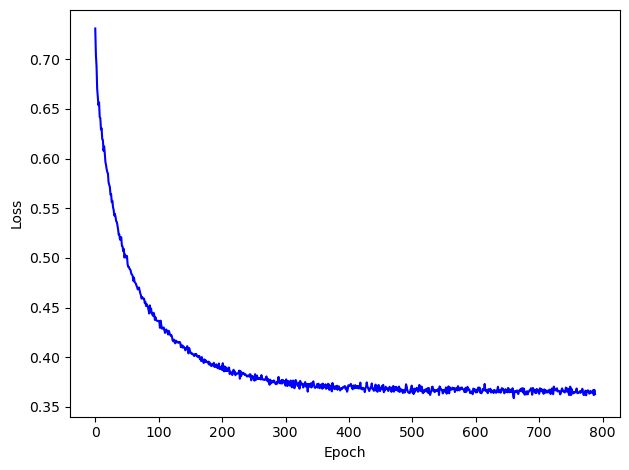

In [13]:
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()

/tmp/ipykernel_3107216/1046449729.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_edge['IRT1_ability'] = ability.ravel()


Difficulty: PearsonRResult(statistic=0.08927646867960594, pvalue=5.80852184964279e-12)
Age-Ability: PearsonRResult(statistic=0.27384798236511776, pvalue=0.0)
Ability: PearsonRResult(statistic=0.5706275099195941, pvalue=0.0)


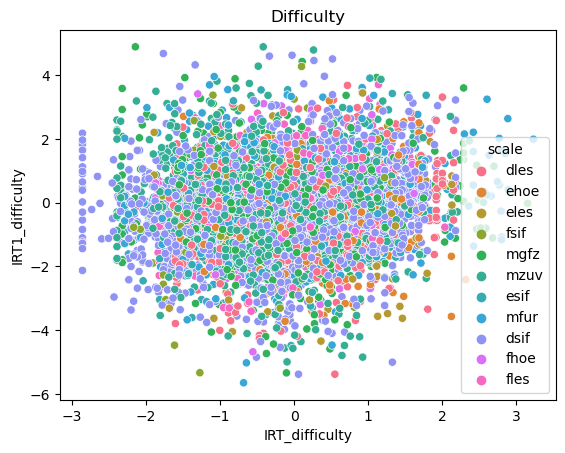

/home/garben/anaconda3/tempnets/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


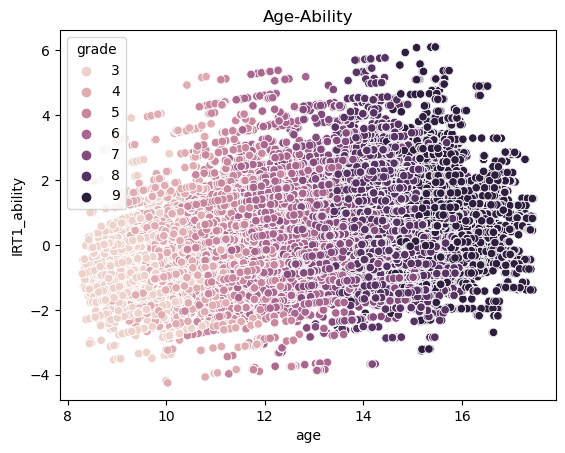

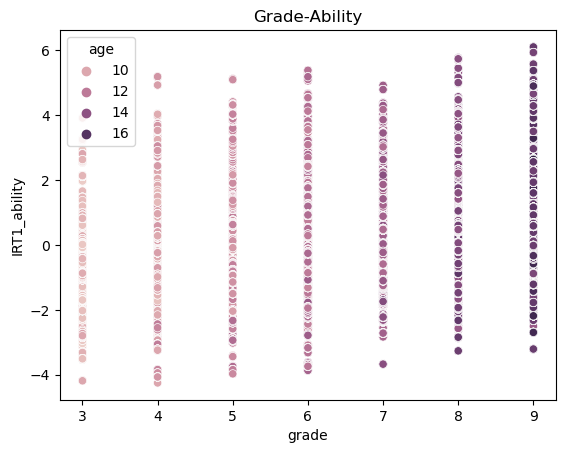

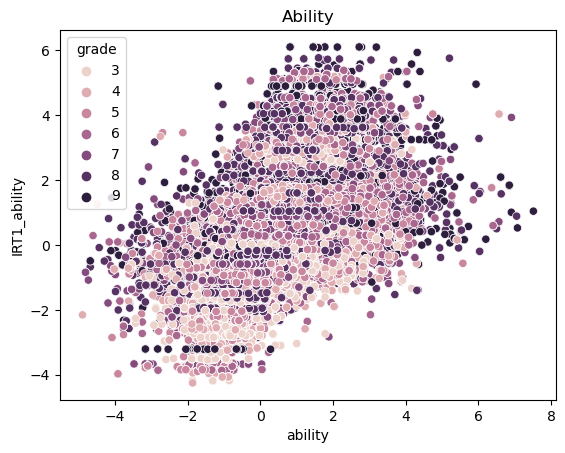

In [14]:
# save IRT parameters to matrix
if OUTNAME == 'IRT' and IRT_DIMS == 1:    
    #z_dict = model.get_embeddings(train_data.to(device))
    z_dict = output_dict['embedding_0']
    df_item['IRT1_difficulty'] = -z_dict['item']
    df_item['IRT1_discrimination'] = z_dict['offset']
    ability = z_dict['ability']
    df_edge['IRT1_ability'] = ability.ravel()
    
    aux_data = (df, df_student, df_item, df_edge, 
    train_losses, 
    train_edge_indices, val_edge_indices, test_edge_indices,
    data.cpu(), train_data.cpu(), val_data.cpu().cpu(), test_data.cpu(),
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

    with open(f'./results/{OUTNAME}_{DATASET}_aux_data_IRT1.pkl', 'wb') as handle:
        pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    df_item_clean = df_item.dropna(subset=['IRT_difficulty', 'IRT1_difficulty'])    
    
    fig = plt.figure()
    sns.scatterplot(x='IRT_difficulty', y='IRT1_difficulty', data=df_item, hue='scale')
    plt.title('Difficulty')
    print('Difficulty:', pearsonr(df_item_clean['IRT1_difficulty'], df_item_clean['IRT_difficulty']))
    
    edge_feat = train_data['student', 'responds', 'item'].edge_attr.detach().cpu().numpy()
    df_edge_clean = df_edge.dropna(subset=['IRT1_ability', 'ability', 'age'])
    fig = plt.figure()
    sns.scatterplot(x='age', y='IRT1_ability', data=df_edge_clean, hue='grade')
    plt.title('Age-Ability')
    
    fig = plt.figure()
    sns.scatterplot(x='grade', y='IRT1_ability', data=df_edge_clean, hue='age')
    plt.title('Grade-Ability')
    print('Age-Ability:', pearsonr(df_edge_clean['age'], df_edge_clean['IRT1_ability']))

    fig = plt.figure()
    sns.scatterplot(x='ability', y='IRT1_ability', data=df_edge_clean, hue='grade')
    plt.title('Ability')
    print('Ability:', pearsonr(df_edge_clean['ability'], df_edge_clean['IRT1_ability']))
    